# About

You can use this notebook as a baseline for 10 different models (VGG16, VGG19, ResNet50, ResNet101, Xception, MobileNet,  DenseNet121, DenseNet169, MobileNetV2 and InceptionV3) in any kind of image classification task.

It's a useful collection from many other notebooks to create single all-in baseline code. Other notebooks can be found at references below. 

In the code, there are some additional parts that you do not have to use in your task. I'll be pointing these out when appropriate. You can ignore, adjust or delete these code blocks.

### Also note that for medical data baseline:
The lack of important parameters such as data source, unique id of patients, patient id of slices taken from 3D images and patient splitting method makes the used Kaggle data set unusable for research. One of the most important concept to consider for deep learning in medical research is the appropriate train-test splitting of patient data due to leakage concerns.

In this notebook, 
- Kaggle baseline data set contains total 6.400 2D slices with unknown location includes 896 Mild Demented, 64 Moderate Demented, 3.200 Non-Demented and 2.240 Very Mild Demented subjects. 
- Kaggle augmented data set contains total 33.984 samples with 8.960 Mild Demented, 6.464 Moderate Demented, 9.600 Non-Demented and 8.960 Very Mild Demented subjects. Augmented data set employed as training set and baseline utilized as test set to simulate common wrong applications in the literature. 

*In the end, this notebook aims to provide a baseline for application of the models. It has almost zero medical reliability by using this data set.*


#### References

* [1](https://www.kaggle.com/code/vishakansubramanian/alzheimer-s-disease-classification-notebook), [2](https://www.kaggle.com/code/uraninjo/state-of-art-models), [3](https://www.kaggle.com/code/kenconstable/alzheimer-s-multi-class-classification)

In [1]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# System libraries
from pathlib import Path
import os.path
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import time

from PIL import Image
from random import randint

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools



from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 

from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101 # ResNet 101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3

import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  2


# BREAK FOR INVESTIGATING THE DATA

In [2]:
#AUGMENTED DATA
aug_data = "../input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"
org_data = "../input/augmented-alzheimer-mri-dataset/OriginalDataset"

In [3]:
image_dir = Path(aug_data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

## Modify or delete get_dataset function completely according to your own data structure.

### This cell contains a function get_dataset that creates a DataFrame with file paths and labels for images. If the augmented parameter is set to 0, it uses the original dataset; otherwise, it uses the augmented dataset. It then retrieves the file paths for JPG images and their corresponding labels, combines them into a DataFrame, and returns it

In [ ]:
def get_dataset(augmented = 0):
    if(augmented == 0):
        image_dir = Path(org_data)
    else:
        image_dir = Path(aug_data)
        
    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df
        

In [4]:
def get_dataset(augmented = 0):
    if(augmented == 0):
        image_dir = Path(org_data)
    else:
        image_dir = Path(aug_data)
        
    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df
        

In [5]:
train_df = get_dataset(1)
test_df = get_dataset(0)

In [6]:
pd.set_option('display.max_colwidth', None)
train_df.head()

,Filepath,Label
0,../input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented/e93f9de2-fdb9-40d6-9796-63d1fa7eaba5.jpg,ModerateDemented
1,../input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented/ef0fc865-7e80-436a-a058-2b1d99af06fb.jpg,ModerateDemented
2,../input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented/aa28cd03-eeca-4dbf-a4f7-8ee3622618a7.jpg,ModerateDemented
3,../input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented/7ad437b5-641c-40ad-9a89-e7431fc48899.jpg,ModerateDemented
4,../input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented/6fbe016a-060e-4977-adb1-1ed74ba2d365.jpg,ModerateDemented


In [7]:
test_df.tail()

,Filepath,Label
6395,../input/augmented-alzheimer-mri-dataset/OriginalDataset/MildDemented/mildDem535.jpg,MildDemented
6396,../input/augmented-alzheimer-mri-dataset/OriginalDataset/MildDemented/mildDem153.jpg,MildDemented
6397,../input/augmented-alzheimer-mri-dataset/OriginalDataset/MildDemented/26 (22).jpg,MildDemented
6398,../input/augmented-alzheimer-mri-dataset/OriginalDataset/MildDemented/mildDem21.jpg,MildDemented
6399,../input/augmented-alzheimer-mri-dataset/OriginalDataset/MildDemented/mildDem557.jpg,MildDemented


# Random 25 pictures for Augmented Samples and Original Samples

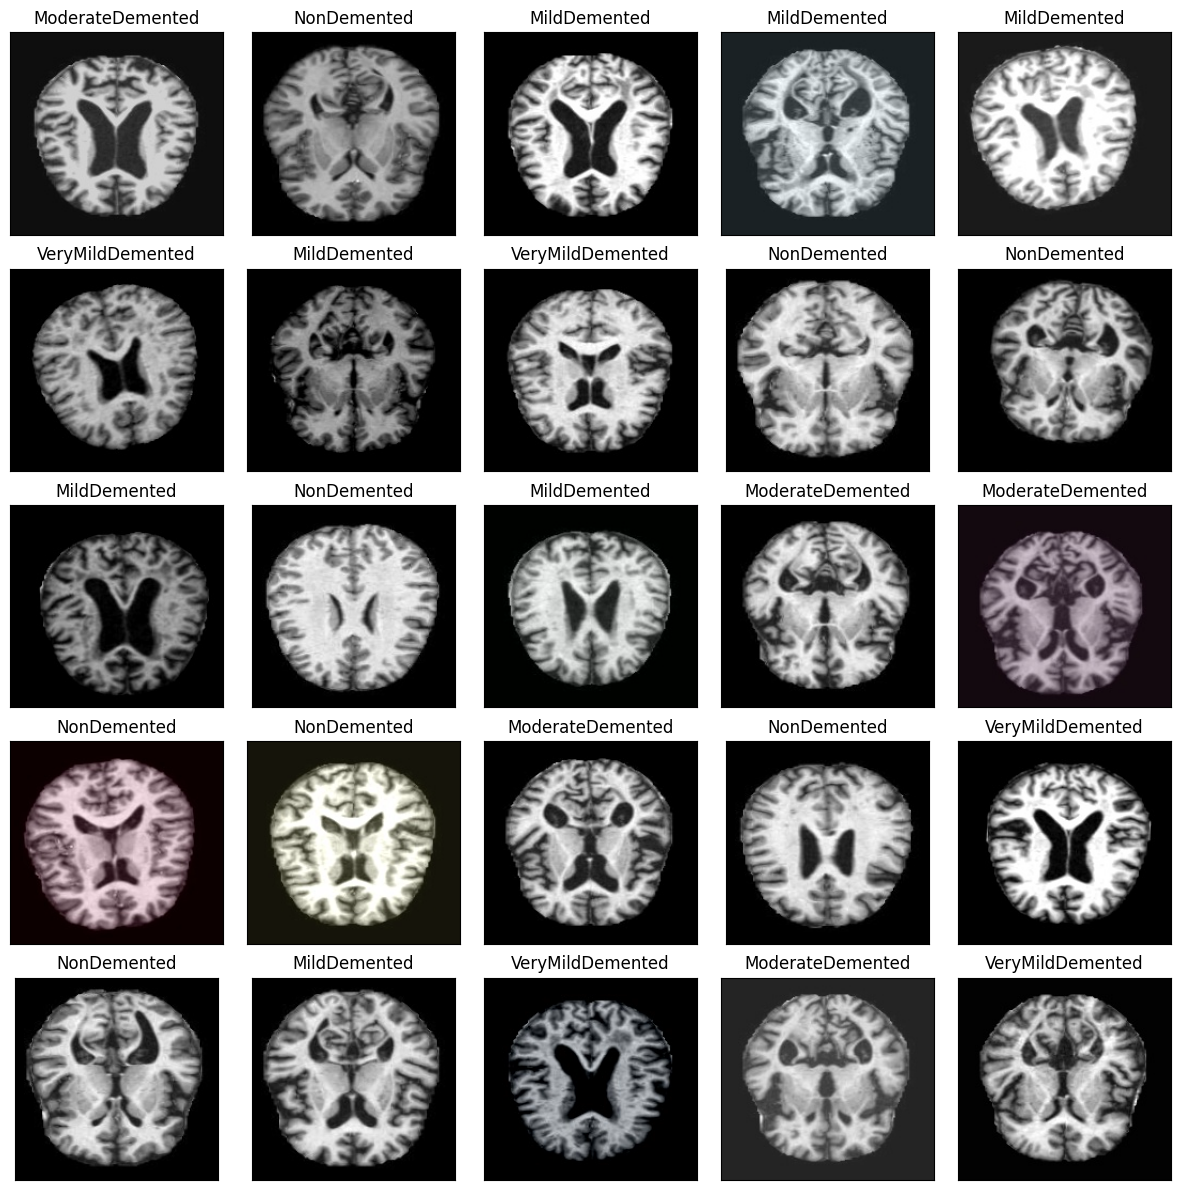

In [8]:
# Display 25 picture of the augmented dataset with their labels
random_index = np.random.randint(0, len(train_df), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(plt.imread(train_df.Filepath[random_index[i]]), cv2.COLOR_BGR2RGB))
    ax.set_title(train_df.Label[random_index[i]])
plt.tight_layout()
plt.savefig("Augmented.pdf")

plt.show()

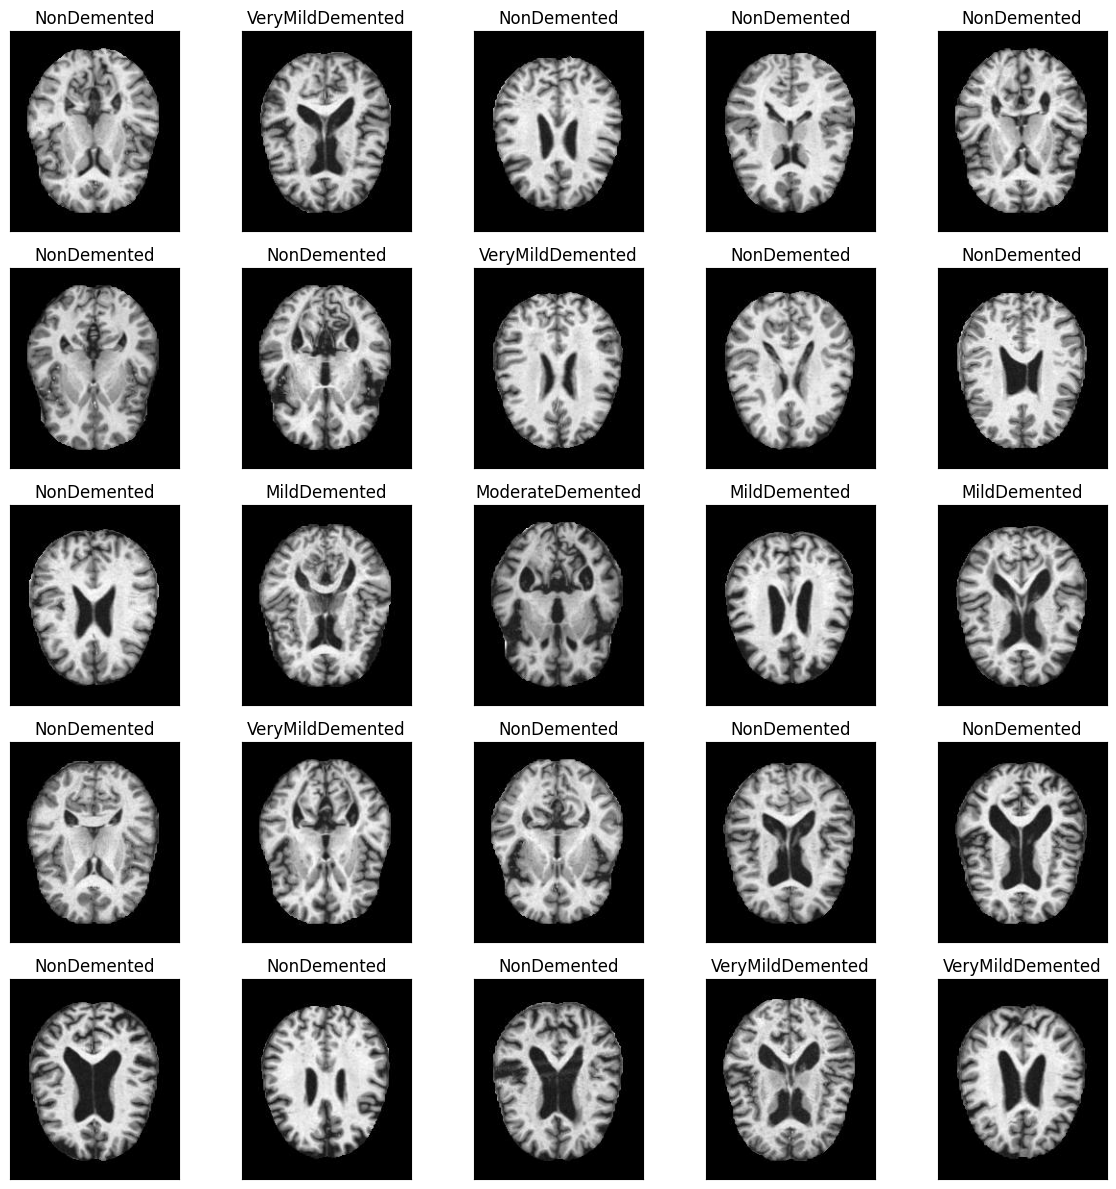

In [9]:
# Display 25 picture of the original dataset with their labels
random_index = np.random.randint(0, len(test_df), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(plt.imread(test_df.Filepath[random_index[i]]), cv2.COLOR_BGR2RGB))
    ax.set_title(test_df.Label[random_index[i]])
plt.tight_layout()
plt.savefig("Original.pdf")
plt.show()

In [10]:
print("Train data set label distribution:\n",train_df.Label.value_counts())

print("\nTest data set label distribution:\n", test_df.Label.value_counts())

Train data set label distribution:
 Label
NonDemented         9600
VeryMildDemented    8960
MildDemented        8960
ModerateDemented    6464
Name: count, dtype: int64

Test data set label distribution:
 Label
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64


# END OF BREAK FOR INVESTIGATING THE DATA

### Directory Setup:

#### base_dir points to the root directory of the Alzheimer's MRI dataset on Kaggle.
#### train_dir and test_dir are set to point to the augmented and original dataset directories, respectively.

In [11]:
base_dir = "/kaggle/input/augmented-alzheimer-mri-dataset/"
root_dir = "./"
train_dir = base_dir + "AugmentedAlzheimerDataset/"
test_dir = base_dir + "OriginalDataset/"

### Class Definitions and Image Dimensions:

#### CLASSES lists the four stages of Alzheimer's disease to be classified.
#### IMG_SIZE and DIM define the image size and dimensions for processing.

In [12]:
#WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

### Data Generators:

#### An ImageDataGenerator (datagen) is initialized for real-time data augmentation, rescaling images, and splitting the training data for validation.
#### train_gen and validation_gen are data generators for training and validation datasets, respectively, created from the augmented data.
#### test_gen and test_gen_plot are data generators for the testing dataset, created from the original data.

In [13]:
datagen = IDG(rescale = 1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True)

validation_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=True)

test_gen = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=6400,
                                             class_mode='categorical')

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [14]:
test_gen_plot = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical')

Found 6400 images belonging to 4 classes.


--------

plot_training_metrics function will be provided most needed result metrics. If you want to adjust and more, feel free to improve.

In [15]:
def plot_training_metrics(train_hist, model, test_gen_plot, y_actual, y_pred, classes, model_name):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    
    # Evaluate the results: 
    #. test_metrics[0] = loss, 
    #  test_metrics[1] = auc, 
    #  test_metrics[2] = acc
    # Evaluate the results:
    test_metrics = model.evaluate(test_gen_plot, verbose = False)
    AUC       = test_metrics[1]*100
    Acc       = test_metrics[2]*100 
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))

    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[AUC/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()

    
     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

In [16]:
def prepare_for_test(model, test_gen):
    data, y_true = test_gen.next()
    y_pred_ = model.predict(data, batch_size = 64)
    y_pred = []
    for i in range(y_pred_.shape[0]):
        y_pred.append(np.argmax(y_pred_[i]))
        
    y_true = np.argmax(y_true, axis=1)
    
    return y_true, y_pred

----

# MODELS #

## VGG19

### This cell configures a VGG19 model for image classification by using pre-trained ImageNet weights, freezing its existing layers, and adding a new output layer to classify images into four Alzheimer's disease stages. The model's summary is then displayed.

In [17]:
vgg = VGG19(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 88, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 88, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 88, 128)       147584    
                                                              

### This cell compiles and trains the VGG19 model using the Adam optimizer and early stopping, and measures the total training time.

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))                                                                                                                              

100/100 [==============================] - 24s 180ms/step

 Model AUC 99.37%, Accuracy 93.14% on Test Data

              precision    recall  f1-score   support

        mild       0.94      0.97      0.95       896
    moderate       1.00      1.00      1.00        64
      normal       0.96      0.92      0.94      3200
   very-mild       0.89      0.94      0.91      2240

    accuracy                           0.93      6400
   macro avg       0.95      0.96      0.95      6400
weighted avg       0.93      0.93      0.93      6400



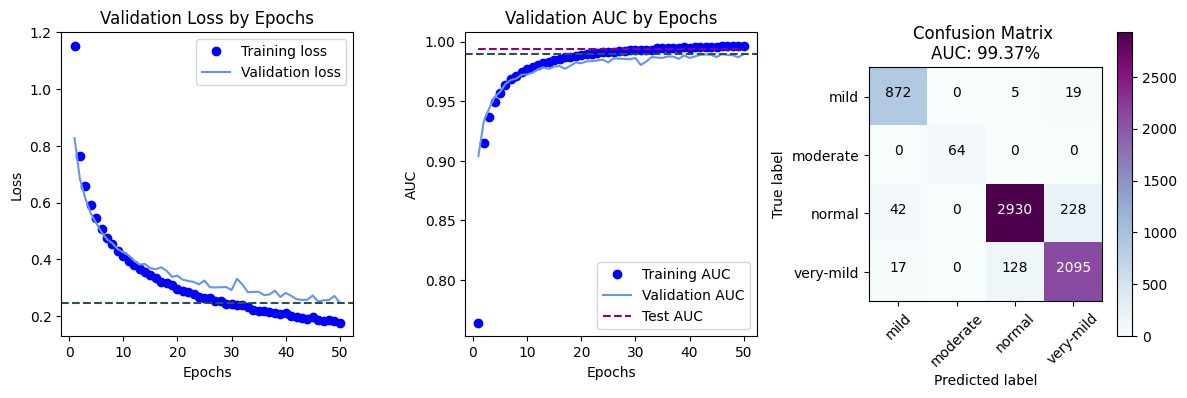

In [19]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "vgg19")

In [20]:
# SAVE MODEL
model_dir = "./alzheimer_vgg19_model"
model.save(model_dir, save_format='h5')
np.save('my_vgg19_history.npy', history.history)
#history=np.load('my_vgg19_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

-----

## VGG16

### This cell configures a VGG16 model for image classification, freezes its layers, adds a flatten and dense layer for output, and displays the model summary.

In [21]:
vgg = VGG16(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 176, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 88, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 88, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 88, 128)       147584    
                                                            

### This cell compiles the VGG16 model, sets up an early stopping callback, trains the model, and prints the total training time.

In [ ]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)
tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

100/100 [==============================] - 15s 152ms/step

 Model AUC 99.65%, Accuracy 94.67% on Test Data

              precision    recall  f1-score   support

        mild       0.95      0.98      0.96       896
    moderate       1.00      1.00      1.00        64
      normal       0.97      0.93      0.95      3200
   very-mild       0.91      0.95      0.93      2240

    accuracy                           0.95      6400
   macro avg       0.96      0.97      0.96      6400
weighted avg       0.95      0.95      0.95      6400



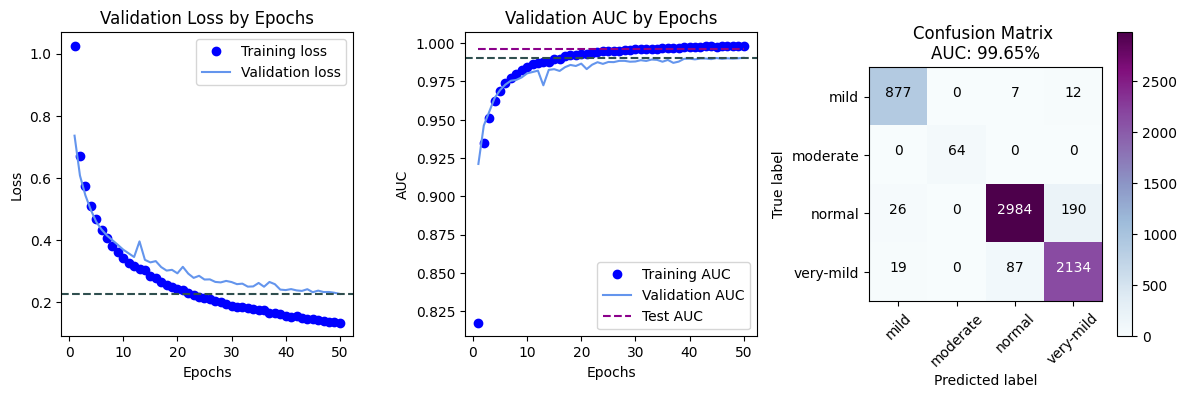

In [23]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "vgg16")

In [24]:
# SAVE MODEL
model_dir = "./alzheimer_vgg16_model"
model.save(model_dir, save_format='h5')
np.save('my_vgg16_history.npy', history.history)
#history=np.load('my_vgg16_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## ResNet50


### This cell sets up and trains a ResNet50 model with early stopping, then prints the training duration.

In [ ]:
rn = ResNet50(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=rn.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

100/100 [==============================] - 14s 112ms/step

 Model AUC 94.46%, Accuracy 76.66% on Test Data

              precision    recall  f1-score   support

        mild       0.59      0.91      0.72       896
    moderate       0.82      1.00      0.90        64
      normal       0.81      0.85      0.83      3200
   very-mild       0.82      0.59      0.69      2240

    accuracy                           0.77      6400
   macro avg       0.76      0.84      0.78      6400
weighted avg       0.78      0.77      0.76      6400



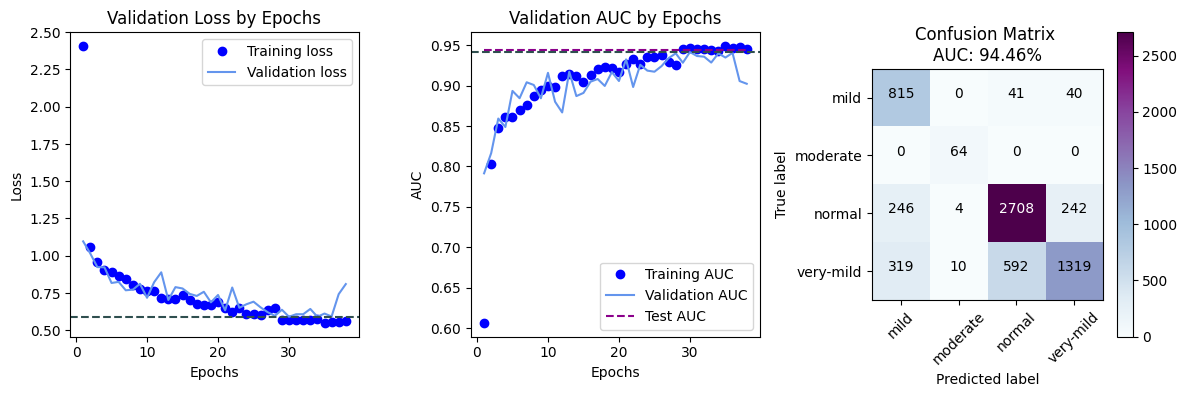

In [26]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "resnet50")

In [27]:
# SAVE MODEL
model_dir = "./alzheimer_resnet50_model"
model.save(model_dir, save_format='h5')
np.save('my_resnet50_history.npy', history.history)
#history=np.load('my_resnet50_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## ResNet 101

### This cell sets up a ResNet101 model for image classification, compiles it, trains it with an early stopping mechanism, and records the training time.

In [28]:
rn = ResNet101(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=rn.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/50
77/77 [==============================] - 124s 2s/step - loss: 7.5620 - auc: 0.6027 - acc: 0.3708 - val_loss: 1.0739 - val_auc: 0.7946 - val_acc: 0.5227
Epoch 2/50
77/77 [==============================] - 116s 1s/step - loss: 1.0730 - auc: 0.8017 - acc: 0.5412 - val_loss: 2.1343 - val_auc: 0.6874 - val_acc: 0.2931
Epoch 3/50
77/77 [==============================] - 116s 2s/step - loss: 1.2988 - auc: 0.7804 - acc: 0.5258 - val_loss: 1.5503 - val_auc: 0.7723 - val_acc: 0.4662
Epoch 4/50
77/77 [==============================] - 119s 2s/step - loss: 1.3343 - auc: 0.7874 - acc: 0.5280 - val_loss: 0.9055 - val_auc: 0.8551 - val_acc: 0.5892
Epoch 5/50
77/77 [==============================] - 119s 2s/step - loss: 1.0536 - auc: 0.8374 - acc: 0.5901 - val_loss: 1.0772 - val_auc: 0.8338 - val_acc: 0.5221
Epoch 6/50
77/77 [==============================] - 119s 2s/step - loss: 1.0347 - auc: 0.8434 - acc: 0.6016 - val_loss

100/100 [==============================] - 21s 188ms/step

 Model AUC 97.15%, Accuracy 84.20% on Test Data

              precision    recall  f1-score   support

        mild       0.70      0.96      0.81       896
    moderate       0.98      1.00      0.99        64
      normal       0.89      0.87      0.88      3200
   very-mild       0.86      0.75      0.80      2240

    accuracy                           0.84      6400
   macro avg       0.86      0.90      0.87      6400
weighted avg       0.85      0.84      0.84      6400



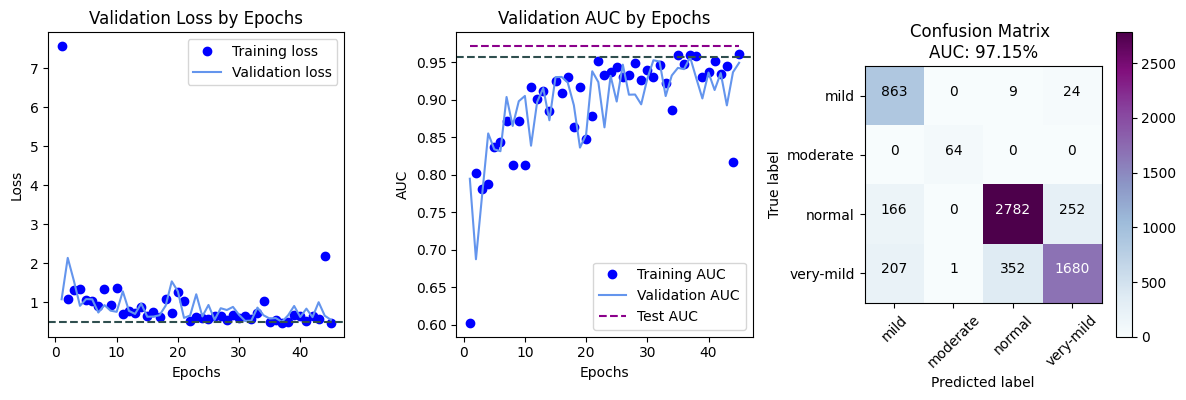

In [29]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "resnet101")

In [30]:
# SAVE MODEL
model_dir = "./alzheimer_resnet101_model"
model.save(model_dir, save_format='h5')
np.save('my_resnet101_history.npy', history.history)
#history=np.load('my_resnet101_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## Xception

### This cell configures the Xception model for image classification, compiles it, trains it with an early stopping callback, and measures the training duration.

In [31]:
model = Xception(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/50
77/77 [==============================] - 124s 1s/step - loss: 1.4323 - auc: 0.8131 - acc: 0.5761 - val_loss: 0.6737 - val_auc: 0.9196 - val_acc: 0.7107
Epoch 2/50
77/77 [==============================] - 95s 1s/step - loss: 0.7080 - auc: 0.9119 - acc: 0.6932 - val_loss: 0.6369 - val_auc: 0.9265 - val_acc: 0.7201
Epoch 3/50
77/77 [==============================] - 95s 1s/step - loss: 0.5414 - auc: 0.9485 - acc: 0.7749 - val_loss: 0.6861 - val_auc: 0.9210 - val_acc: 0.6904
Epoch 4/50
77/77 [==============================] - 96s 1s/step - loss: 0.5254 - auc: 0.9506 - acc: 0.7762 - val_loss: 0.5109 - val_auc: 0.9540 - val_acc: 0.7878
Epoch 5/50
77/77 [==============================] - 95s 1s/step - loss: 0.4491 - auc: 0.9651 - acc: 0.8180 - val_loss: 0.5860 - val_auc: 0.9416 - val_acc: 0.7693
Epoch 6/50
77/77 [==============================] - 96s 1s/step - loss: 0.4460 - auc: 0.9646 - acc: 0.8147 - val_loss: 0.468

100/100 [==============================] - 18s 148ms/step

 Model AUC 99.11%, Accuracy 91.86% on Test Data

              precision    recall  f1-score   support

        mild       0.88      0.97      0.92       896
    moderate       1.00      1.00      1.00        64
      normal       0.95      0.91      0.93      3200
   very-mild       0.90      0.91      0.90      2240

    accuracy                           0.92      6400
   macro avg       0.93      0.95      0.94      6400
weighted avg       0.92      0.92      0.92      6400



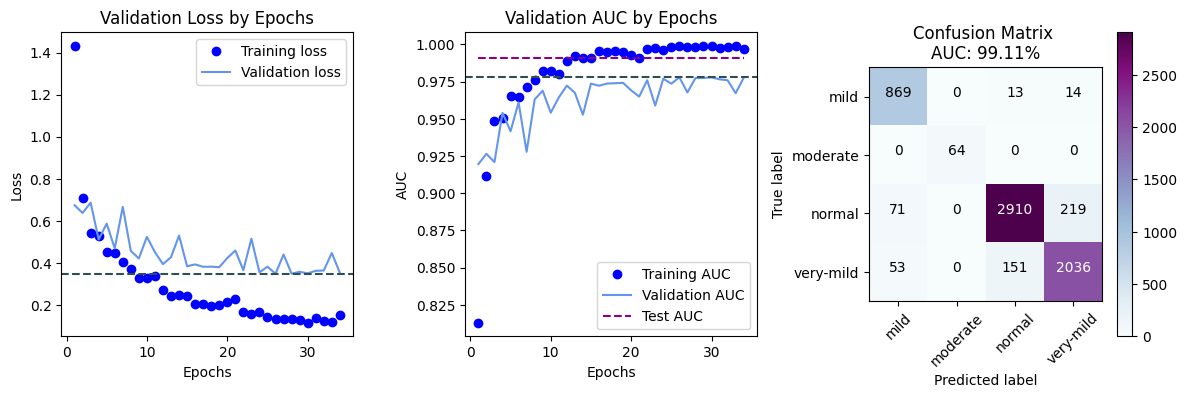

In [32]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "xception")

In [33]:
# SAVE MODEL
model_dir = "./alzheimer_xception_model"
#model.save(model_dir, save_format='h5')
#np.save('my_xception_history.npy', history.history)
#history=np.load('my_xception_history.npy',allow_pickle='TRUE').item()
#premodel = tensorflow.keras.models.load_model(model_dir)

----

## MobileNet

### This cell sets up the MobileNet model for classification, compiles it, trains it with an early stopping mechanism, and logs the training time.

In [34]:
model = MobileNet(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/50
77/77 [==============================] - 97s 1s/step - loss: 2.1683 - auc: 0.8106 - acc: 0.5993 - val_loss: 0.5502 - val_auc: 0.9476 - val_acc: 0.7728
Epoch 2/50
77/77 [==============================] - 106s 1s/step - loss: 0.4049 - auc: 0.9706 - acc: 0.8371 - val_loss: 0.4970 - val_auc: 0.9568 - val_acc: 0.7946
Epoch 3/50
77/77 [==============================] - 93s 1s/step - loss: 0.3019 - auc: 0.9838 - acc: 0.8849 - val_loss: 0.3398 - val_auc: 0.9784 - val_acc: 0.8626
Epoch 4/50
77/77 [==============================] - 90s 1s/step - loss: 0.2100 - auc: 0.9930 - acc: 0.9255 - val_loss: 0.3279 - val_auc: 0.9800 - val_acc: 0.8696
Epoch 5/50
77/77 [==============================] - 90s 1s/step - loss: 0.1668 - auc: 0.9961 - acc: 0.9457 - val_loss: 0.2711 - val_auc: 0.9863 - val_acc: 0.8967
Epoch 6/50
77/77 [==============================] - 89s 1s/step - loss: 0.1257 - auc: 0.9982 - acc: 0.9644 - val_loss: 0.257

100/100 [==============================] - 5s 43ms/step

 Model AUC 99.66%, Accuracy 95.17% on Test Data

              precision    recall  f1-score   support

        mild       0.94      0.99      0.97       896
    moderate       1.00      1.00      1.00        64
      normal       0.95      0.97      0.96      3200
   very-mild       0.96      0.92      0.94      2240

    accuracy                           0.95      6400
   macro avg       0.96      0.97      0.96      6400
weighted avg       0.95      0.95      0.95      6400



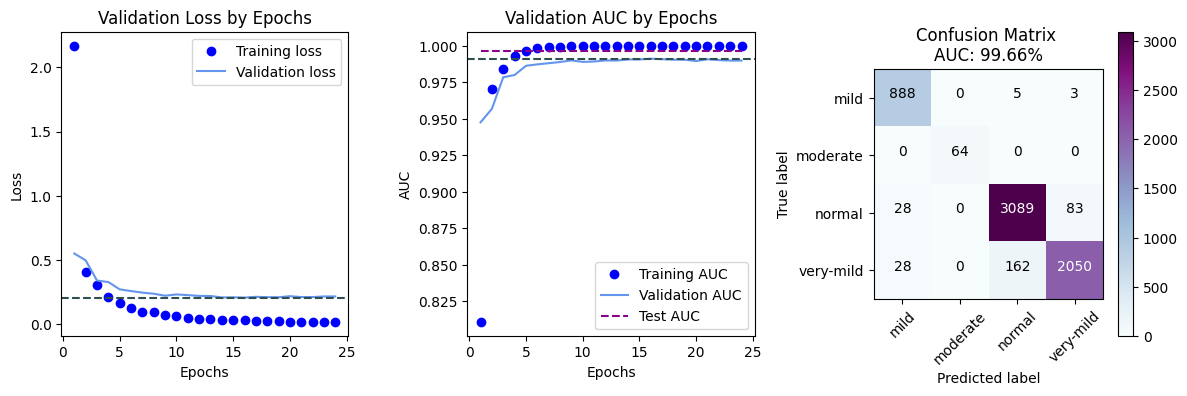

In [35]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "mobilenet")

In [36]:
# SAVE MODEL
model_dir = "./alzheimer_mobilenet_model"
model.save(model_dir, save_format='h5')
np.save('my_mobilenet_history.npy', history.history)
#history=np.load('my_mobilenet_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## MobileNetV2

### This cell configures the MobileNetV2 model for image classification, compiles it, trains it with early stopping, and tracks the training time.

In [ ]:
def get_dataset(augmented = 0):
    if(augmented == 0):
        image_dir = Path(org_data)
    else:
        image_dir = Path(aug_data)
        
    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df
        

### This cell sets up the MobileNetV2 model for classification, compiles it, trains it with an early stopping mechanism, and logs the training time.

In [37]:
model = MobileNetV2(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
77/77 [==============================] - 98s 1s/step - loss: 3.7852 - auc: 0.7682 - acc: 0.5600 - val_loss: 0.5571 - val_auc: 0.9447 - val_acc: 0.7705
Epoch 2/50
77/77 [==============================] - 92s 1s/step - loss: 0.4802 - auc: 0.9588 - acc: 0.8055 - val_loss: 0.7942 - val_auc: 0.9166 - val_acc: 0.6833
Epoch 3/50
77/77 [==============================] - 91s 1s/step - loss: 0.3639 - auc: 0.9764 - acc: 0.8582 - val_loss: 0.3983 - val_auc: 0.9715 - val_acc: 0.8431
Epoch 4/50
77/77 [==============================] - 91s 1s/step - loss: 0.2508 - auc: 0.9904 - acc: 0.9130 - val_loss: 0.3426 - val_auc: 0.9787 - val_acc: 0.8655
Epoch 5/50
77/77 [==============================] - 90s 1s/step - loss: 0.2052 - auc: 0.9942 - acc: 0.9332 - val_loss: 0.3507 - val_auc: 0.9774 - val_acc: 0.8543
Epoch 6/50
77/77 [==============================] - 91s 1s/step - loss: 0.1957 - auc: 0.9942 - acc: 0.9334 - val_loss: 0.3573 -

100/100 [==============================] - 6s 50ms/step

 Model AUC 98.69%, Accuracy 90.06% on Test Data

              precision    recall  f1-score   support

        mild       0.86      0.94      0.90       896
    moderate       1.00      0.95      0.98        64
      normal       0.91      0.92      0.92      3200
   very-mild       0.90      0.85      0.88      2240

    accuracy                           0.90      6400
   macro avg       0.92      0.92      0.92      6400
weighted avg       0.90      0.90      0.90      6400



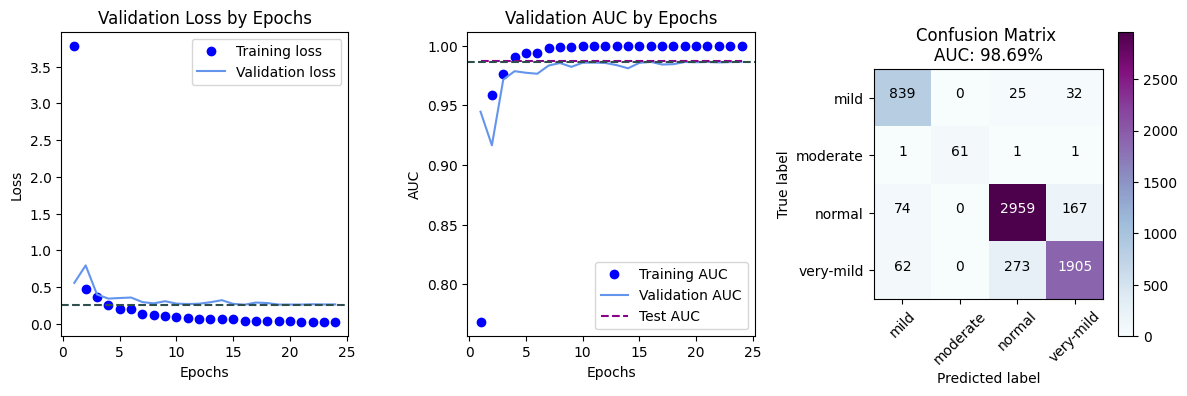

In [38]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "mobilenetv2")

In [39]:
# SAVE MODEL
model_dir = "./alzheimer_mobilenetv2_model"
model.save(model_dir, save_format='h5')
np.save('my_mobilenetv2_history.npy', history.history)
#history=np.load('my_mobilenetv2_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

-----

## DenseNet169

### This cell sets up the DenseNet169 model for classification, compiles it, trains it with an early stopping mechanism, and logs the training time.

In [40]:
model = DenseNet169(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

51877672/51877672 [==============================] - 0s 0us/step
Epoch 1/50
77/77 [==============================] - 127s 1s/step - loss: 2.5538 - auc: 0.7560 - acc: 0.5444 - val_loss: 0.6677 - val_auc: 0.9221 - val_acc: 0.7104
Epoch 2/50
77/77 [==============================] - 93s 1s/step - loss: 0.5715 - auc: 0.9422 - acc: 0.7606 - val_loss: 0.5005 - val_auc: 0.9569 - val_acc: 0.7964
Epoch 3/50
77/77 [==============================] - 94s 1s/step - loss: 0.4628 - auc: 0.9637 - acc: 0.8139 - val_loss: 0.4646 - val_auc: 0.9623 - val_acc: 0.8108
Epoch 4/50
77/77 [==============================] - 94s 1s/step - loss: 0.4135 - auc: 0.9709 - acc: 0.8366 - val_loss: 0.4135 - val_auc: 0.9704 - val_acc: 0.8323
Epoch 5/50
77/77 [==============================] - 94s 1s/step - loss: 0.3672 - auc: 0.9775 - acc: 0.8602 - val_loss: 0.4060 - val_auc: 0.9707 - val_acc: 0.8317
Epoch 6/50
77/77 [==============================] - 93s 1s/step - loss: 0.3387 - auc: 0.9808 - acc: 0.8712 - val_loss: 0.452

100/100 [==============================] - 19s 133ms/step

 Model AUC 99.34%, Accuracy 93.03% on Test Data

              precision    recall  f1-score   support

        mild       0.88      0.97      0.92       896
    moderate       1.00      1.00      1.00        64
      normal       0.93      0.96      0.94      3200
   very-mild       0.95      0.88      0.91      2240

    accuracy                           0.93      6400
   macro avg       0.94      0.95      0.94      6400
weighted avg       0.93      0.93      0.93      6400



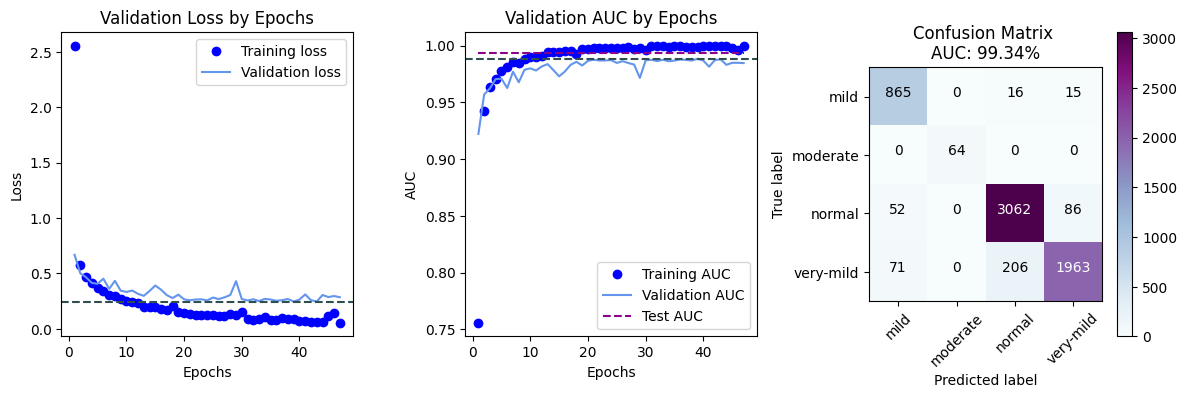

In [41]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "densenet169")

In [42]:
# SAVE MODEL
model_dir = "./alzheimer_densenet169_model"
model.save(model_dir, save_format='h5')
np.save('my_densenet169_history.npy', history.history)
#history=np.load('my_densenet169_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## DenseNet121


### This cell configures the DenseNet121 model for image classification, compiles it, trains it with an early stopping callback, and measures the training duration.

In [43]:
model = DenseNet121(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/50
77/77 [==============================] - 105s 1s/step - loss: 2.2363 - auc: 0.7635 - acc: 0.5346 - val_loss: 0.6771 - val_auc: 0.9191 - val_acc: 0.7151
Epoch 2/50
77/77 [==============================] - 92s 1s/step - loss: 0.6364 - auc: 0.9283 - acc: 0.7292 - val_loss: 0.5935 - val_auc: 0.9371 - val_acc: 0.7437
Epoch 3/50
77/77 [==============================] - 92s 1s/step - loss: 0.5341 - auc: 0.9498 - acc: 0.7790 - val_loss: 0.5638 - val_auc: 0.9426 - val_acc: 0.7525
Epoch 4/50
77/77 [==============================] - 92s 1s/step - loss: 0.4532 - auc: 0.9647 - acc: 0.8183 - val_loss: 0.4650 - val_auc: 0.9623 - val_acc: 0.8099
Epoch 5/50
77/77 [==============================] - 95s 1s/step - loss: 0.4177 - auc: 0.9699 - acc: 0.8342 - val_loss: 0.4067 - val_auc: 0.9716 - val_acc: 0.8431
Epoch 6/50
77/77 [==============================] - 92s 1s/step - loss: 0.3657 - auc: 0.9779 - acc: 0.8610 - val_loss: 0.496

100/100 [==============================] - 13s 109ms/step

 Model AUC 99.30%, Accuracy 92.64% on Test Data

              precision    recall  f1-score   support

        mild       0.88      0.97      0.92       896
    moderate       1.00      1.00      1.00        64
      normal       0.94      0.94      0.94      3200
   very-mild       0.93      0.88      0.91      2240

    accuracy                           0.93      6400
   macro avg       0.94      0.95      0.94      6400
weighted avg       0.93      0.93      0.93      6400



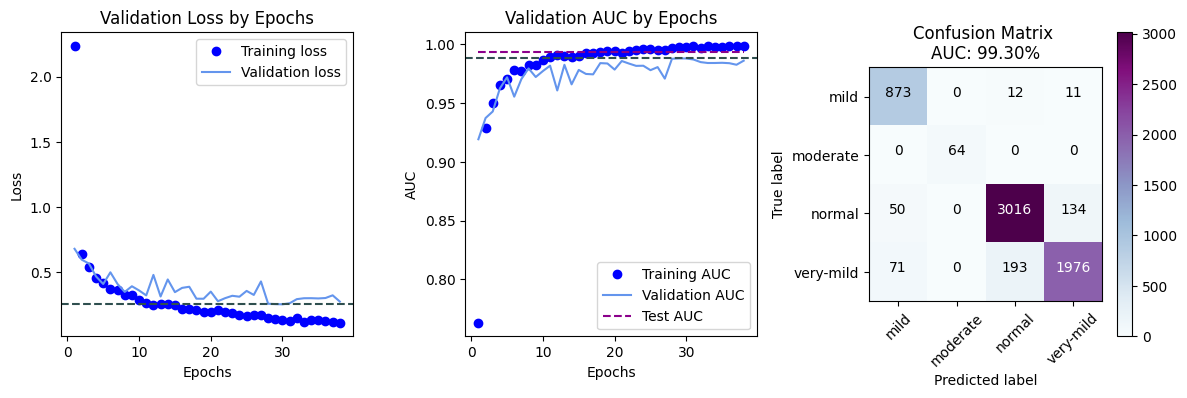

In [44]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "densenet121")

In [45]:
# SAVE MODEL
model_dir = "./alzheimer_densenet121_model"
model.save(model_dir, save_format='h5')
np.save('my_densenet121_history.npy', history.history)
#history=np.load('my_densenet121_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)

----

## InceptionV3

### This cell sets up the InceptionV3 model for image classification, compiles it, trains it with an early stopping callback, and tracks the training time.

In [46]:
model = InceptionV3(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/50
77/77 [==============================] - 112s 1s/step - loss: 3.3102 - auc: 0.7448 - acc: 0.5206 - val_loss: 0.7047 - val_auc: 0.9114 - val_acc: 0.6904
Epoch 2/50
77/77 [==============================] - 94s 1s/step - loss: 0.6773 - auc: 0.9196 - acc: 0.7143 - val_loss: 0.6804 - val_auc: 0.9198 - val_acc: 0.7054
Epoch 3/50
77/77 [==============================] - 91s 1s/step - loss: 0.6179 - auc: 0.9334 - acc: 0.7381 - val_loss: 0.6616 - val_auc: 0.9283 - val_acc: 0.7428
Epoch 4/50
77/77 [==============================] - 93s 1s/step - loss: 0.5233 - auc: 0.9513 - acc: 0.7824 - val_loss: 0.6535 - val_auc: 0.9309 - val_acc: 0.7343
Epoch 5/50
77/77 [==============================] - 91s 1s/step - loss: 0.5051 - auc: 0.9550 - acc: 0.7942 - val_loss: 0.5227 - val_auc: 0.9513 - val_acc: 0.7802
Epoch 6/50
77/77 [==============================] - 93s 1s/step - loss: 0.4122 - auc: 0.9697 - acc: 0.8353 - val_loss: 0.646

100/100 [==============================] - 12s 74ms/step

 Model AUC 98.80%, Accuracy 90.16% on Test Data

              precision    recall  f1-score   support

        mild       0.85      0.97      0.91       896
    moderate       0.98      1.00      0.99        64
      normal       0.91      0.93      0.92      3200
   very-mild       0.92      0.82      0.87      2240

    accuracy                           0.90      6400
   macro avg       0.91      0.93      0.92      6400
weighted avg       0.90      0.90      0.90      6400



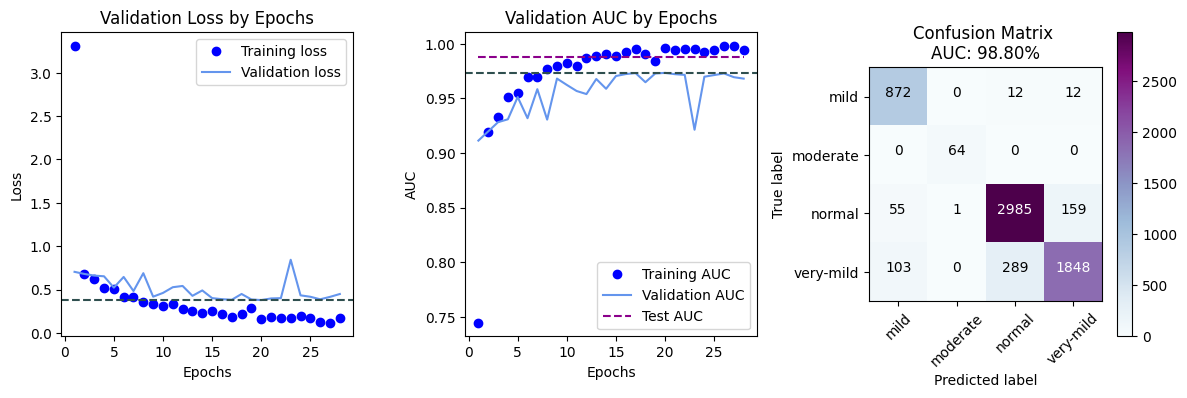

In [47]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "inceptionv3")

In [48]:
# SAVE MODEL
model_dir = "./alzheimer_inceptionv3_model"
model.save(model_dir, save_format='h5')
np.save('my_inceptionv3_history.npy', history.history)
#history=np.load('my_inceptionv3_history.npy',allow_pickle='TRUE').item()
#pretrained_model = tensorflow.keras.models.load_model(model_dir)